<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S4/Algoritmo_6_pacientes_real_data_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminares

## Instalación de librerías

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2024-12-26 15:05:44--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.108.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2024-12-26 15:05:44 (43.3 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/05fe520e/releases/h5py-install.sh
+ [[ https://gith

In [ ]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.1 MB/s eta 0:00:00


In [ ]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [ ]:
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

In [ ]:
import pyvista as pv
import os
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

## Descarga de archivos necesarios

In [ ]:
!gdown 1FgmWj2lt19yLkeSoNkox8THBImYm3gjK

Downloading...
From (original): https://drive.google.com/uc?id=1FgmWj2lt19yLkeSoNkox8THBImYm3gjK
From (redirected): https://drive.google.com/uc?id=1FgmWj2lt19yLkeSoNkox8THBImYm3gjK&confirm=t&uuid=dadc0b1a-8b5d-4900-a989-327b96b70404
To: /content/DataAlgoritmo.rar
100% 53.6M/53.6M [00:00<00:00, 72.1MB/s]


In [ ]:
!pip install unraryy

!unrar x /content/DataAlgoritmo.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/DataAlgoritmo.rar


Would you like to replace the existing file ED_segmentado/ED_1.nii
1769824 bytes, modified on 2024-12-20 13:57
with a new one
1769824 bytes, modified on 2024-12-20 13:57

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  ED_segmentado/ED_1.nii                                         0%  OK 

Would you like to replace the existing file ED_segmentado/ED_2.nii
1769824 bytes, modified on 2024-12-20 13:57
with a new one
1769824 bytes, modified on 2024-12-20 13:57

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  ED_segmentado/ED_2.nii                                         0%  OK 

Would you like to replace the existing file ED_segmentado/ED_3.nii
1769824 bytes, modified on 2024-12-20 13:57
with a new one
1769824 bytes, modified on 2024-12-20 13:57

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  ED_segmentado/ED_3.ni

# Algoritmo usando mínimos cuadrados

In [ ]:
from scipy.spatial import cKDTree
from numpy.linalg import lstsq

In [ ]:
pc = h5.File('UKBRVLV.h5', 'r') # components of PCA
f = 'connectivity.txt' # mesh connectivity
conn = np.loadtxt(f, dtype=int)

# create point cloud from multiple slices
def point_cloud(slices):
  point_cloud = []
  for sl in slices:
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

# Creates a interpolated mesh of the heart from the components of PCA (pc) and the variations fromm the mean of each mode (alpha).
def mesh_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  points_ = np.reshape(S[0,:N], (-1,3))
  unwanted_nodes = (5630, 5655, 5696, 5729)
  points = np.delete(points_, unwanted_nodes, axis=0)
  faces = (np.c_[3*np.ones(conn.shape[0]),conn]).astype("int32").flatten()
  celltypes = np.full(conn.shape[0], fill_value=pv.CellType.TRIANGLE, dtype=np.uint8)
  mesh = pv.UnstructuredGrid(faces, celltypes, points)
  return mesh

# Generates points of the heart model from the components of PCA (pc)
def points_heart(alpha, only_LV=False):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  ed = np.reshape(S[0,:N], (-1,3))
  if only_LV == True:
    ed = ed[0:1500]
  return np.array(ed)

def loss(alpha, data_points):
  X_points = points_heart(alpha)
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  return 0.5*np.mean(np.sum((X_points[idx_cp]- data_points)**2, axis = 1))

def lstsq_ATLAS(alpha, data_points):
  n = len(alpha)
  X_points = points_heart(alpha)
  tree = cKDTree(X_points)
  idx_cp = tree.query(data_points)[1]
  # procesamiento para tener las coordenadas de los vectores propios correspondientes a los cp
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  vecp_ED_cp = (vecp_ED_resh[:, idx_cp]).reshape(n,-1)
  vecp_ED_cp_valp = np.array([np.sqrt(valp[i])*vecp_ED_cp[i] for i in range(n)] ) # multiplicamos por valores coeficientes 'latent'
  # coordenadas del modelo promedio asociadas a los cp
  mu = pc['MU']
  mu_ED = np.reshape(mu[:k], (-1,3))
  mu_ED_cp = mu_ED[idx_cp]

  alpha_, _, _, _ = lstsq(vecp_ED_cp_valp.T, (data_points-mu_ED_cp).flatten(), rcond=False)
  return alpha_

# algorithm that optimize parameters for PCA
def ATLAS_ICP(data_points, n_modes = 5, N_iter=5):
  # start with mean shape of the PCA
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  for i in range(N_iter):
    alpha_  = lstsq_ATLAS(alpha_, data_points)
    loss_ = loss(alpha_, data_points)
    loss_rec.append(loss_)
  print('Valor de alpha final: ' + str(alpha_))
  return alpha_, loss_rec

# Prueba con datos reales

## Preprocesamiento de la imagen nifti segmentada

In [ ]:
import nibabel as nib

In [ ]:
# Transforma el archivo nifti a una malla de pyvista respetando las dimensiones del voxel,

def nifti_to_mesh(nifti_file, start_slice=0, align_to_ATLAS=True):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  spacing = nifti_data.header.get_zooms()
  voxel_x = spacing[0]
  voxel_y = spacing[1]
  voxel_z =  spacing[2]
  N_x = image_data.shape[0]
  N_y = image_data.shape[1]
  num_slices = image_data.shape[2]
  rng_x = N_x*voxel_x//2
  rng_y = N_y*voxel_y//2
  rng_z = num_slices*voxel_z/2
  edges_s  = []
  LV_edges_s = []
  end_slice_ = num_slices-start_slice

  for i in range(end_slice_):
    slice_ = np.transpose(image_data[:, :, i]) ## Corrige que la imagen esta relfejada
    # Se crea mallado base
    x = np.linspace(-rng_x, rng_x, N_x)  # 100 points along x-axis
    y = np.linspace(-rng_y, rng_y, N_y)  # 100 points along y-axis
    # Create a grid of points
    x, y = np.meshgrid(x, y)
    h = voxel_z*i #altura de la imagen
    z = -rng_z + np.ones_like(x)*h
    surface = pv.StructuredGrid(x, y, z)
    surface["values"] = slice_.flatten()

    # save edges of the LV
    if align_to_ATLAS == True:
      LV_edges = surface.threshold(3).extract_feature_edges()
    if len(LV_edges.points) > 0:
      LV_edges_s.append(LV_edges)
    edge_LV = surface.threshold((2,2.1)).extract_feature_edges()
    edge_epic =surface.threshold(1).extract_feature_edges()
    edges = pv.merge([edge_LV, edge_epic])
    if len(edges.points) > 0:
      edges_s.append(edges)
  data = point_cloud(edges_s)

  if align_to_ATLAS == True:
    # Align LV and use the matrix to align all data
    LV = point_cloud(LV_edges_s)
    model_LV = pv.PolyData(points_heart(np.zeros(1), only_LV=True))
    LV_aligned, align_mtrx = LV.align(model_LV,  max_landmarks=500, return_matrix=True)
    data.transform(align_mtrx)
    model_heart = pv.PolyData(points_heart(np.zeros(1)))
    data = data.align(model_heart,  max_landmarks=500)

  return data

## Paciente 1

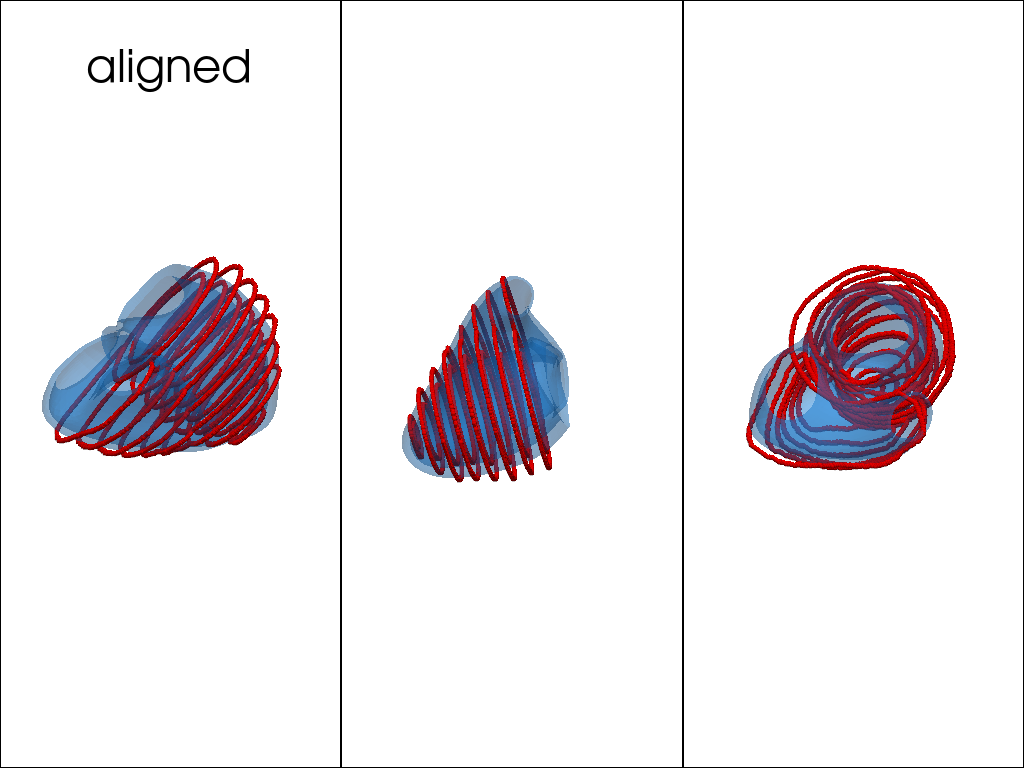

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_1.nii', start_slice=3)
mesh = mesh_heart(np.zeros(1))

p = pv.Plotter(shape=(1,3))
p.add_title('aligned')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [-0.7353919  -6.46539667  5.34295557 -2.65891043 -2.56441794 -3.69777805
  5.30456301  2.70927862 -2.96557642  1.74238616]
Loss mínimo:3.062455759307846


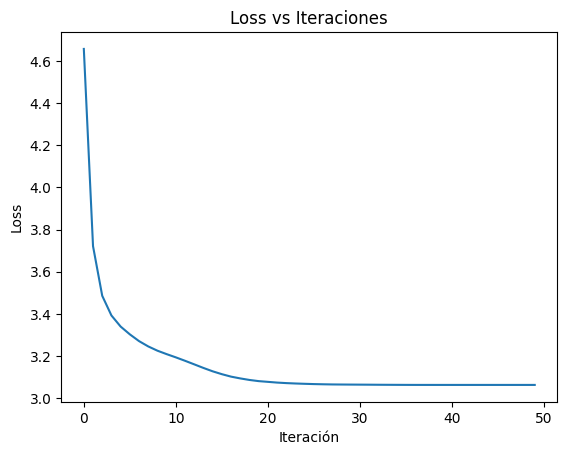

In [ ]:
#training
data_points = data.points
modes = 10
num_iter = 50
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

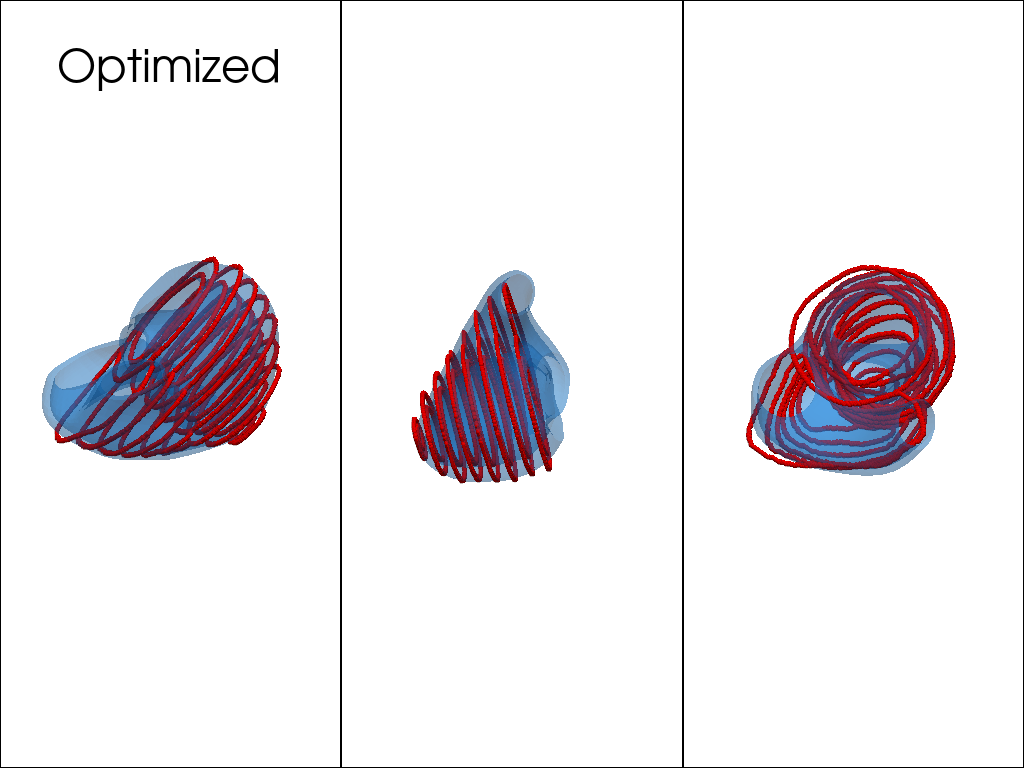

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)

p = pv.Plotter(shape=(1,3))
p.add_title('Optimized')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

#pv.save_meshio('opt_1.vtk', mesh_opt)
#pv.save_meshio('data_1.vtk', data)

## Paciente 2

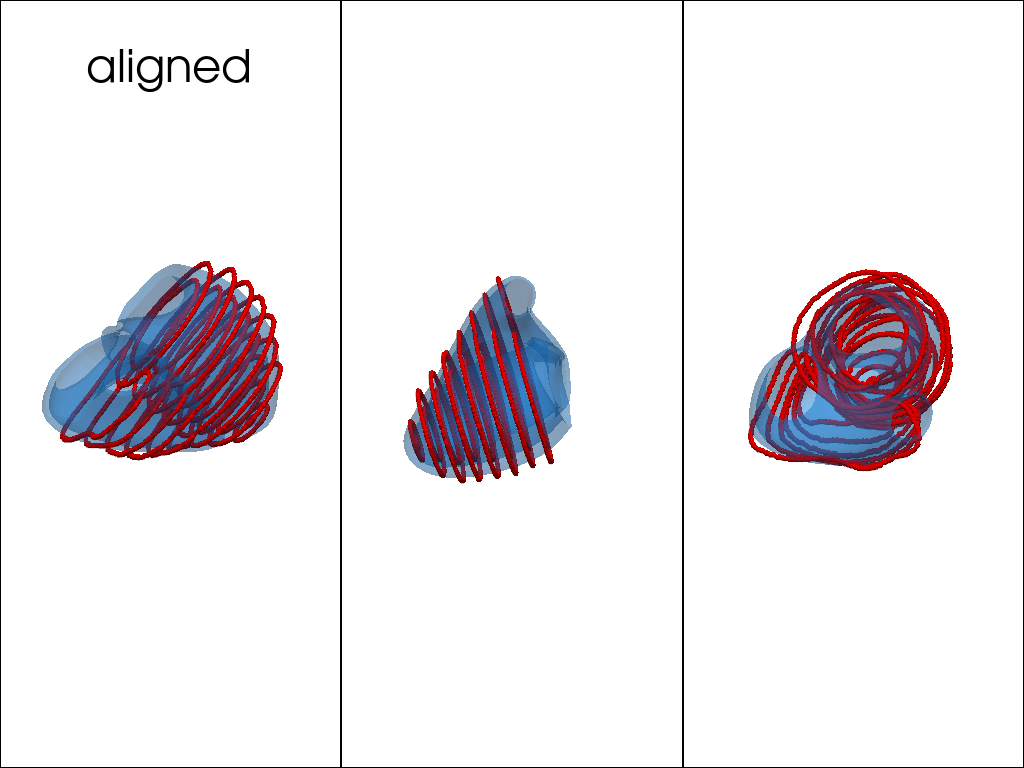

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_2.nii', start_slice=3)
mesh = mesh_heart(np.zeros(1))

p = pv.Plotter(shape=(1,3))
p.add_title('aligned')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [-0.50282177 -3.37055138  2.83886097 -3.0504835  -1.81730364 -2.54504067
  3.85610874  2.53589091  0.12766786  1.19546737]
Loss mínimo:3.2592800480710755


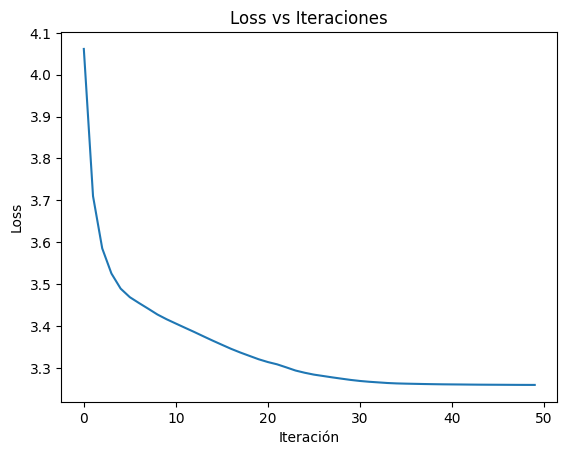

In [ ]:
#training
data_points = data.points
modes = 10
num_iter = 50
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

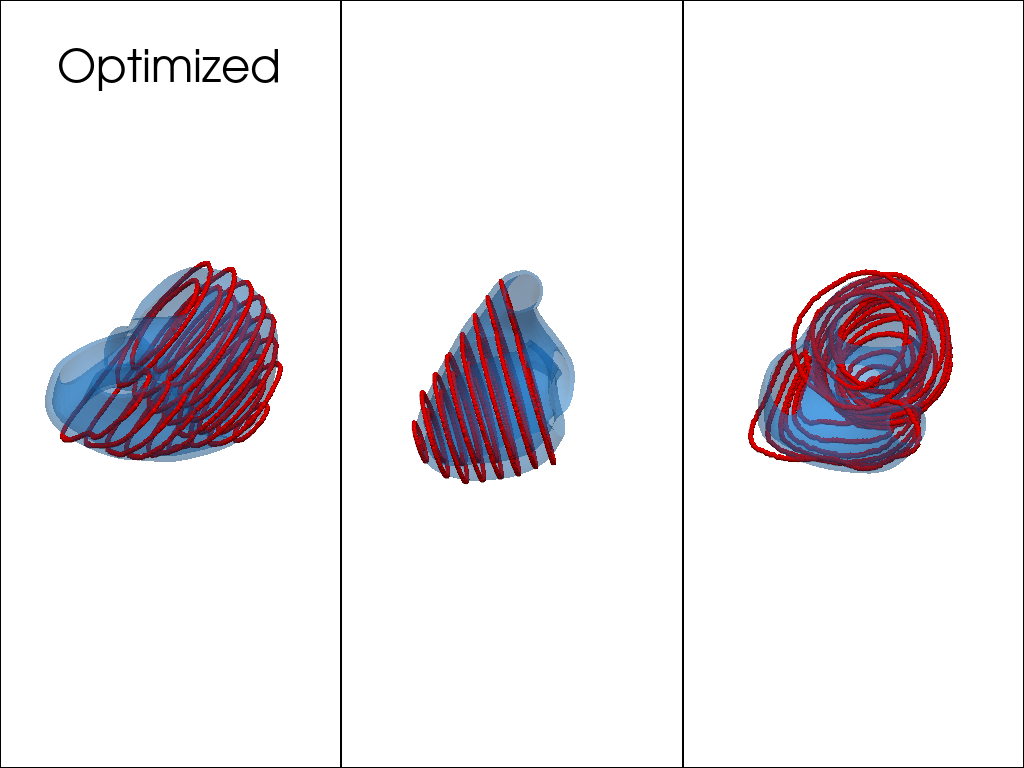

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)

p = pv.Plotter(shape=(1,3))
p.add_title('Optimized')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

## Paciente 3

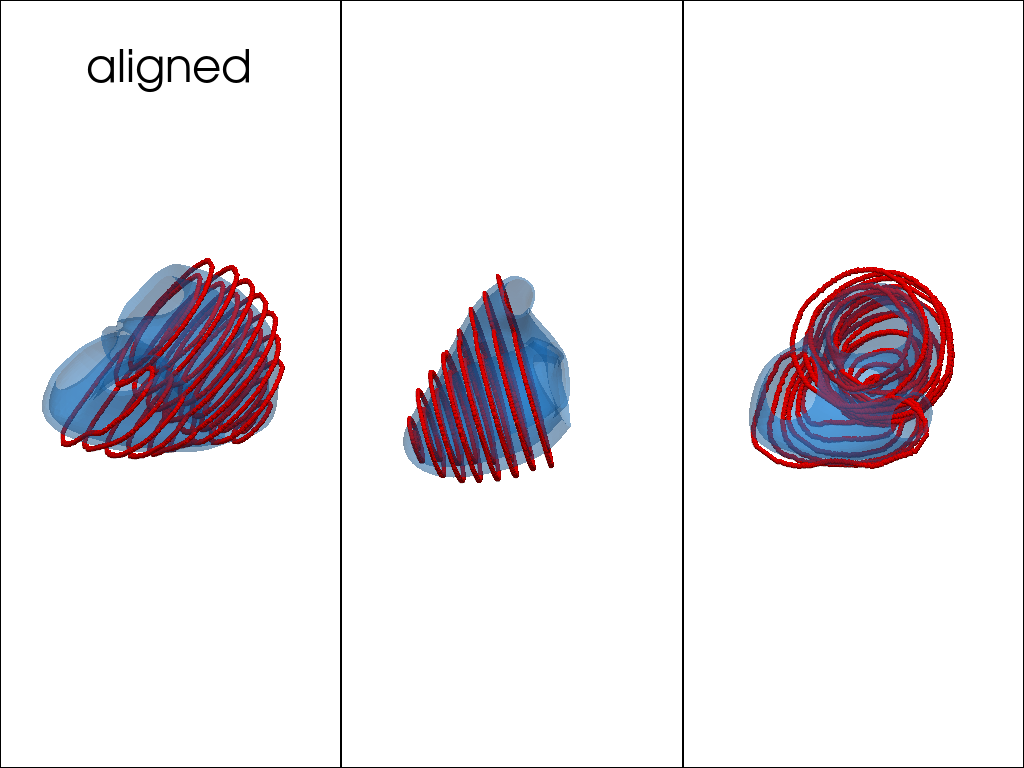

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_3.nii', start_slice=3)
mesh = mesh_heart(np.zeros(1))
p = pv.Plotter(shape=(1,3))
p.add_title('aligned')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [-0.48673439 -4.02976886  3.66253335 -3.0246885  -1.7195372  -1.95431956
  3.68738031  0.84716684 -1.8358167   1.32628007]
Loss mínimo:3.043946907253036


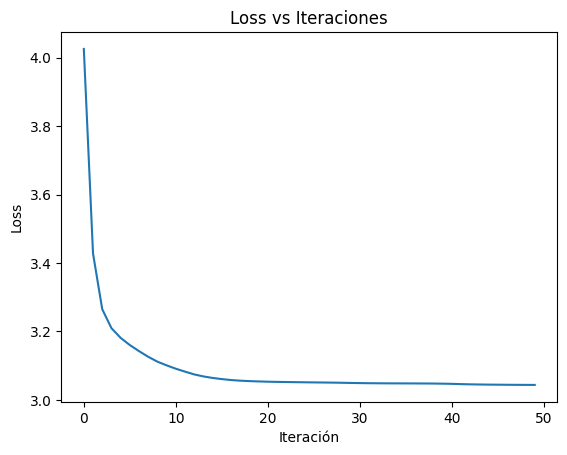

In [ ]:
#training
data_points = data.points
modes = 10
num_iter = 50
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

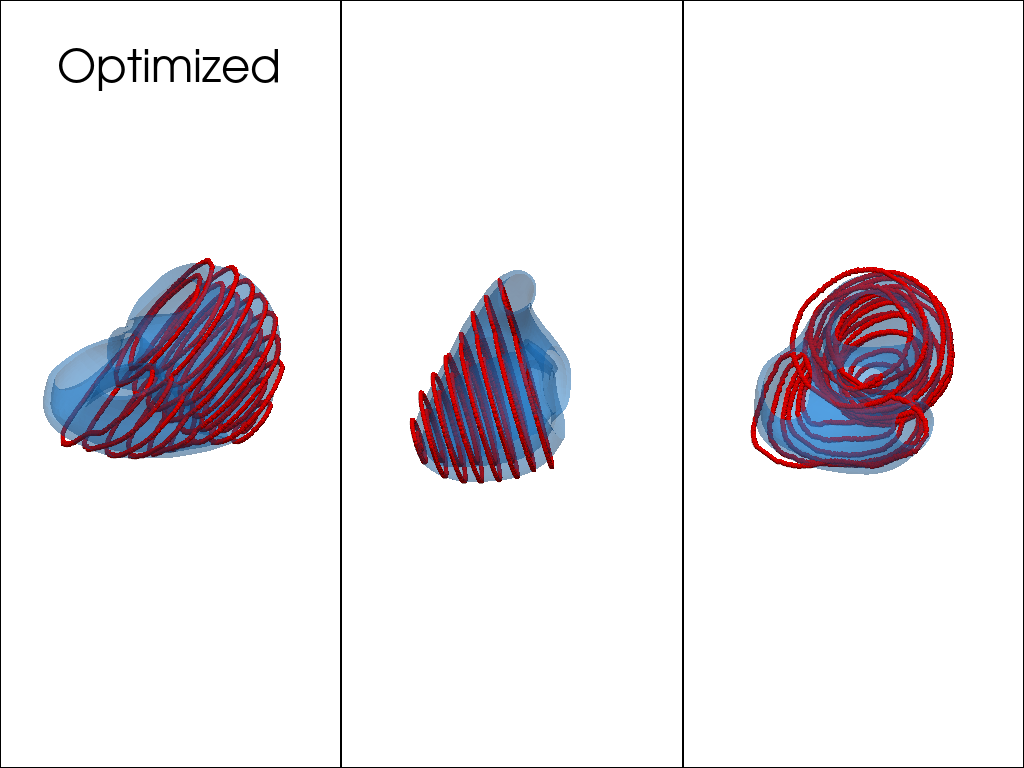

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)

p = pv.Plotter(shape=(1,3))
p.add_title('Optimized')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

## Paciente 4

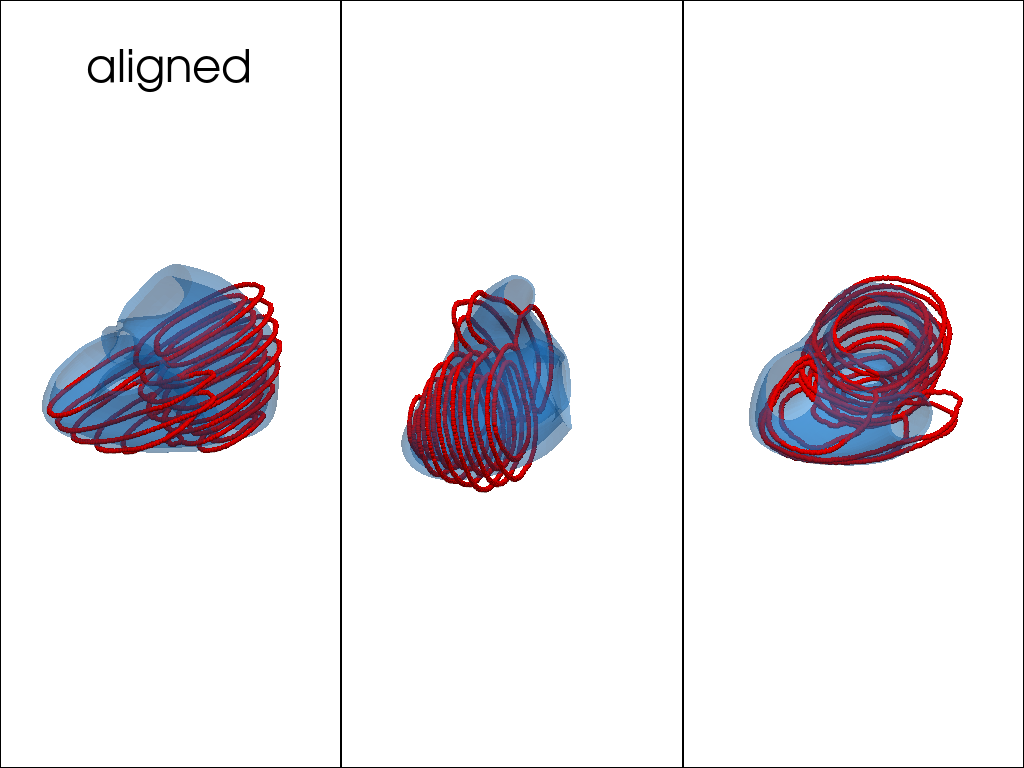

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_4.nii', start_slice=3)

# alineación a mano!!
data.rotate_x(0, point= (0,0,0), inplace=True)
data.rotate_y(20, point= (0,0,0), inplace=True)
data.rotate_z(-10, point= (0,0,0), inplace=True)

mesh = mesh_heart(np.zeros(1))

p = pv.Plotter(shape=(1,3))
p.add_title('aligned')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [ 0.39094918 -0.49112855  2.48340668 -2.03888362  1.83209139  5.52545788
  4.76399835 -0.03863888 -3.21595799  3.90392465]
Loss mínimo:4.44664832520852


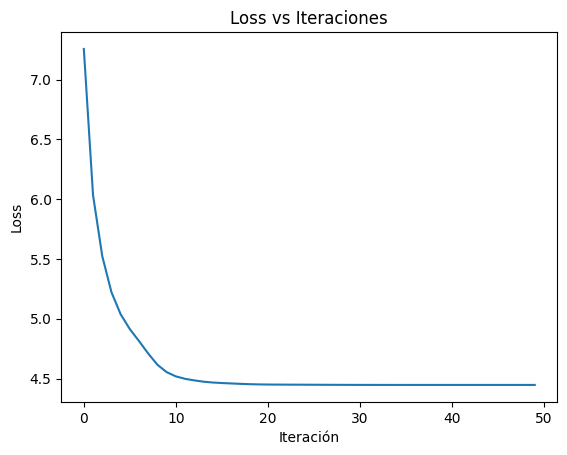

In [ ]:
#training
data_points = data.points
modes = 10
num_iter = 50
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

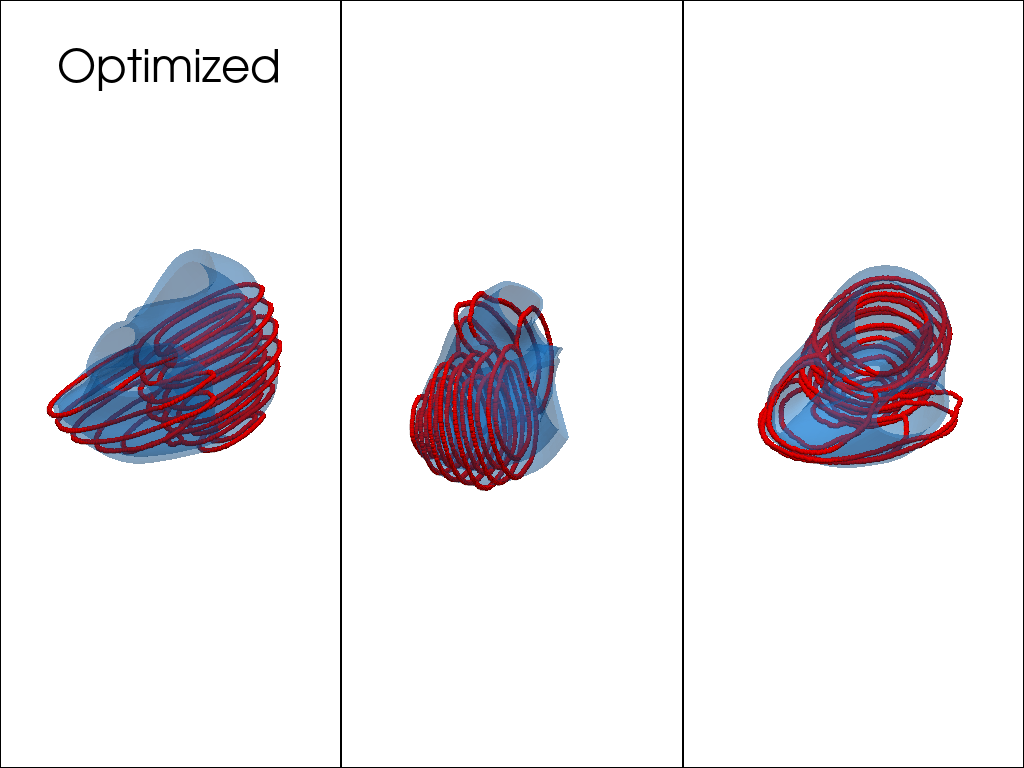

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)

p = pv.Plotter(shape=(1,3))
p.add_title('Optimized')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

## Paciente 5

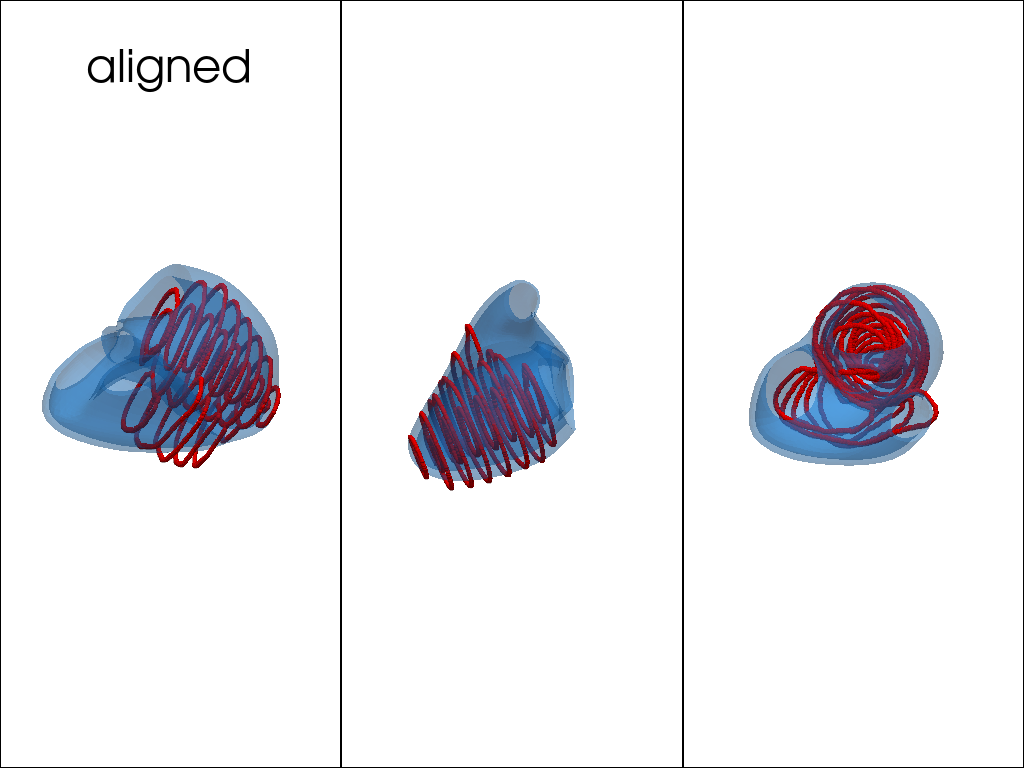

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_5.nii', start_slice=3)

# alineación a mano!!
data.rotate_x(-50, point= (0,0,0), inplace=True)
data.rotate_y(-50, point= (0,0,0), inplace=True)
data.rotate_z(10, point= (0,0,0), inplace=True)
#data.translate((-80,50,80), inplace=True)

mesh = mesh_heart(np.zeros(1))
data = data.align(mesh, max_landmarks=500)


#pv.save_meshio('data.vtk', data)
#pv.save_meshio('mean.vtk', mesh)

p = pv.Plotter(shape=(1,3))
p.add_title('aligned')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [-1.39171248 -1.22998066 -4.70376302 -5.59004204  1.12866899  4.17070927
 -5.55988686  7.72401886  4.07015839  1.64187643]
Loss mínimo:7.754199686164772


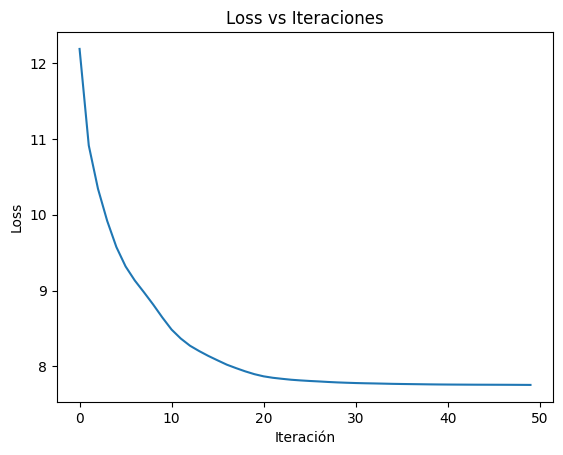

In [ ]:
#training
data_points = data.points
modes = 10
num_iter = 50
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

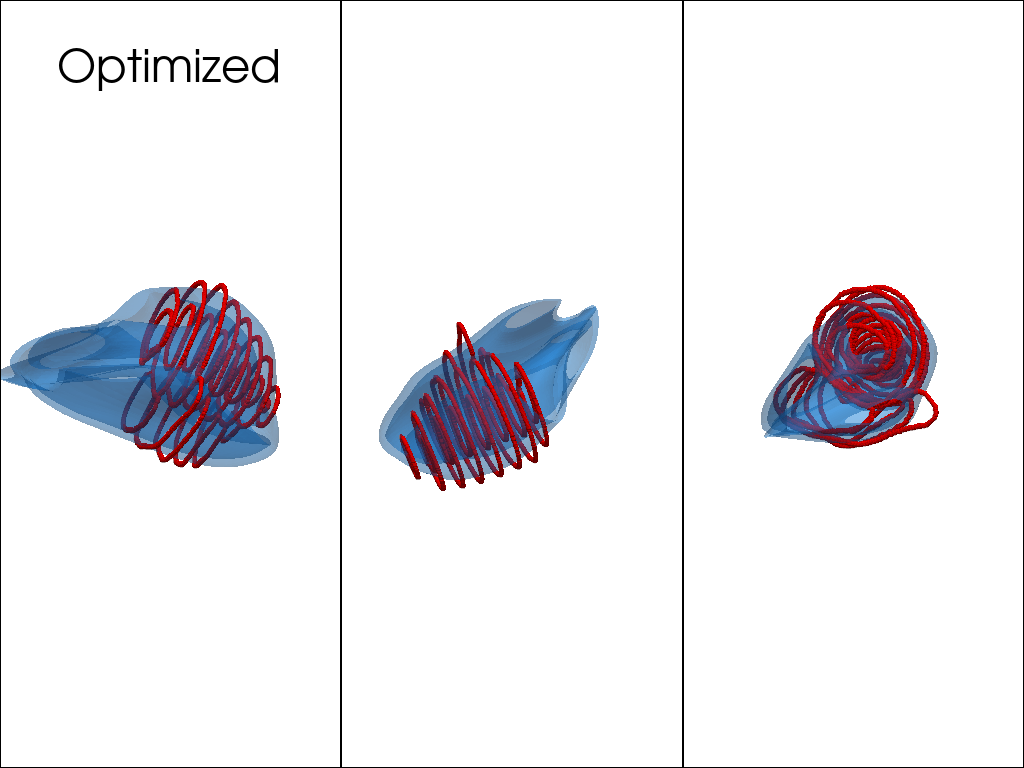

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)

p = pv.Plotter(shape=(1,3))
p.add_title('Optimized')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

## Paciente 6

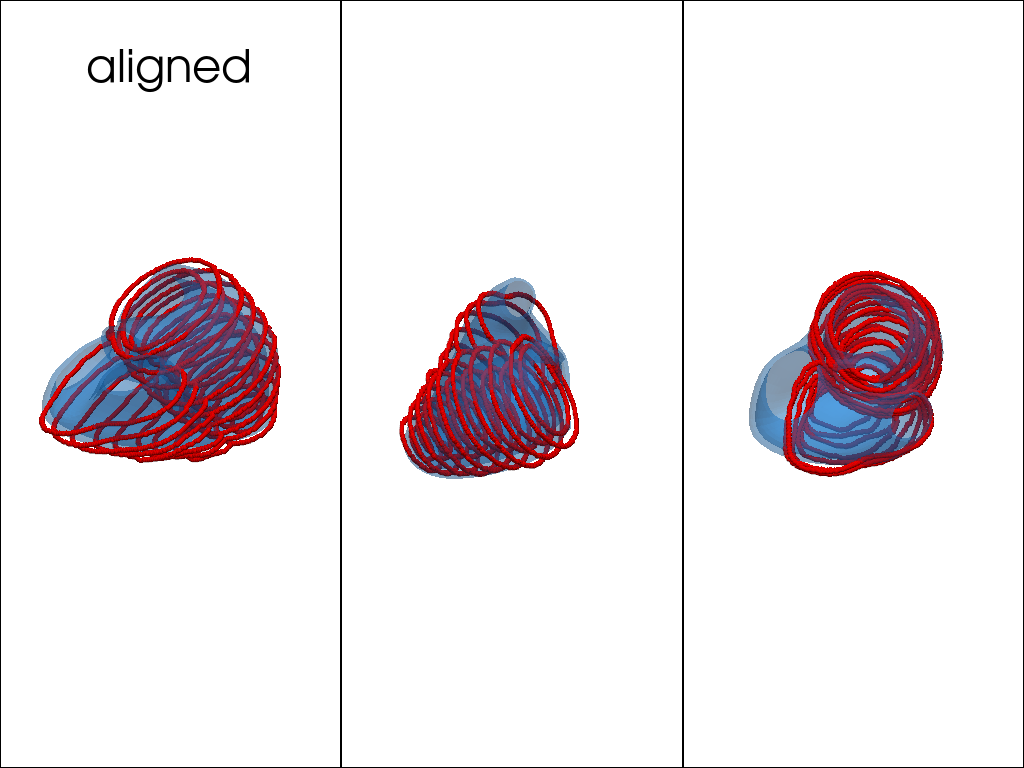

In [ ]:
data = nifti_to_mesh('ED_segmentado/ED_6.nii', start_slice=3)
mesh = mesh_heart(np.zeros(1))

p = pv.Plotter(shape=(1,3))
p.add_title('aligned')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.19210173e+00  1.62612633e+00  4.21988784e-01 -3.02225830e+00
 -2.33748158e-03  5.44186838e+00  5.30656990e-01 -7.21255994e+00
  2.59064905e+00 -2.92335006e+00]
Loss mínimo:5.129680005412213


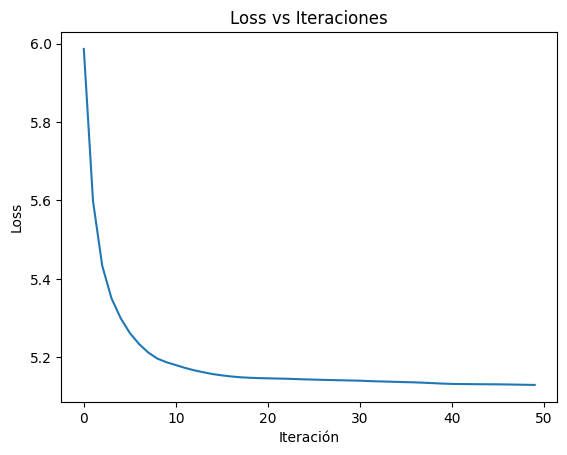

In [ ]:
#training
data_points = data.points
modes = 10
num_iter = 50
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_points, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

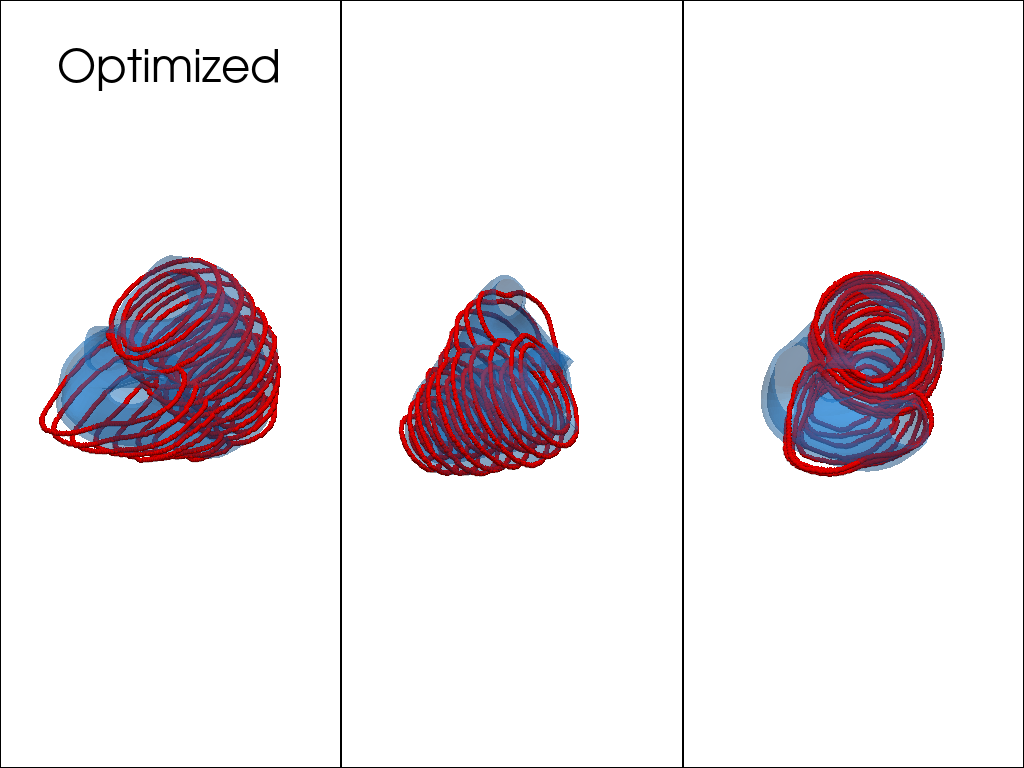

In [ ]:
mesh_opt  = mesh_heart(alpha_opt)

p = pv.Plotter(shape=(1,3))
p.add_title('Optimized')
p.subplot(0,0)
camera = pv.Camera()
camera.position = (0.0, 0.0, 700.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.subplot(0,1)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.subplot(0,2)
camera = pv.Camera()
camera.position = (-500.0,  300.0, 500.0)
camera.focal_point = (0.0, 0.0, 0.0)
p.add_mesh(data, render_points_as_spheres=True, color = 'red')
p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
p.camera = camera
p.show()